<a href="https://colab.research.google.com/github/CVasquezroque/RP-G1/blob/main/CNN_LSTM_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En esta implementación del modelo se buscó utilizar la misma distribución de datos del modelo implementado por CNN-CWT y bajo los mismos hiperparámetros, sin embargo dentro de los resultados obtenidos no se obtiene una mejora , esto podria deberse a la distribución que se tiene de cada una de las clases, donde se tiene muchos más valores de la clase 0 ['N'] en comparación a las otras clases

In [1]:
!wget -r -N -q -c -np https://physionet.org/files/mitdb/1.0.0/

In [2]:
!pip --q install wfdb

     |████████████████████████████████| 143kB 5.5MB/s 


In [3]:
import pywt
import math
import wfdb
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import numpy as np
from pathlib import Path

import os
import glob
import scipy.signal as sg
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D,InputLayer,LSTM
from keras.optimizers import  Adam
from keras.losses import mean_squared_error
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
#from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from keras.activations import relu,sigmoid

In [4]:
PATH = Path("physionet.org/files/mitdb/1.0.0/")

In [5]:
train_records = [
    '101', '106', '108', '109', '112', '114', '115', '116', '118', '119',
    '122', '124', '201', '203', '205', '207', '208', '209', '215', '220',
    '223', '230'
]

test_records = [
    '100', '103', '105', '111', '113', '117', '121', '123', '200', '202',
    '210', '212', '213', '214', '219', '221', '222', '228', '231', '232',
    '233', '234'
]

In [6]:
def align_peaks(filtered_signal,newR,r_peaks,sampling_rate,tol):
  for r_peak in r_peaks:
      r_left = np.maximum(r_peak - int(tol * sampling_rate), 0)
      r_right = np.minimum(r_peak + int(tol * sampling_rate), len(filtered_signal))
      newR.append(r_left + np.argmax(filtered_signal[r_left:r_right]))
  r_peaks = np.array(newR, dtype="int")
  return r_peaks

In [7]:
def beat_segmentation(records,PATH,fs,invalid_labels,before=99,after=160):
  x,y = [],[]
  for record in records:
    signal,meta = wfdb.rdsamp((PATH / record).as_posix(),channels=[0])
    ann = wfdb.rdann((PATH / record).as_posix(),'atr')
    r_peaks, labels = ann.sample, np.array(ann.symbol)
    indices = [i for i, label in enumerate(labels) if label not in invalid_labels]
    r_peaks, labels = r_peaks[indices], labels[indices]
    tol = 0.05
    newR = []
    r_peaks = align_peaks(signal,newR,r_peaks,fs,tol)
    temp_sig = signal.flatten()
    baseline = sg.medfilt(sg.medfilt(temp_sig, int(0.2 * fs) - 1), int(0.6 * fs) - 1)
    filtered_signal = temp_sig - baseline
    filtered_signal = filtered_signal.reshape(len(filtered_signal),1)
    normalized_signal = filtered_signal / np.mean(filtered_signal[r_peaks])
    AAMI = {
    "N": 0, "L": 0, "R": 0, "e": 0, "j": 0,  # N
    "A": 1, "a": 1, "S": 1, "J": 1,  # SVEB
    "V": 2, "E": 2,  # VEB
    "F": 3,  # F
    "/": 4, "f": 4, "Q": 4  # Q
    }
    categories = [AAMI[label] for label in labels]
    for i in range(len(r_peaks)):
      if i == 0 or i == len(r_peaks) - 1:
        continue
      if categories[i] == 4:  # remove AAMI Q class
        continue     
      
      seg_signal = normalized_signal[r_peaks[i] - before: r_peaks[i+1] + after]
      x.append(seg_signal)
      y.append(categories[i])
  return x,y

In [8]:
fs = 360
invalid_labels = ['|', '~', '!', '+', '[', ']', '"', 'x']

In [9]:
X_train,Y_train = beat_segmentation(train_records,PATH,fs,invalid_labels)

In [10]:
X_test,Y_test = beat_segmentation(test_records,PATH,fs,invalid_labels)

In [11]:
len(X_train),len(Y_train),len(X_test),len(Y_test)

(50969, 50969, 49661, 49661)

In [12]:

def uniform_signal(x):
  x2 = []
  for i in x:
    if i.shape[0]<1000:
      z_pad = i.flatten()
      z_pad = np.pad(z_pad, (0, 1000-len(z_pad)), 'constant')
      z_pad = z_pad.reshape((1000,1))
      x2.append(z_pad)
    else:
      if i.shape[0]>=1000:
        x2.append(i[:1000])
  return x2

def myencoder(data_y):
  enc = OneHotEncoder(sparse=False)
  enc.fit(data_y.reshape(-1,1))
  enc.categories_
  Y = enc.transform(data_y.reshape(-1,1))
  return Y, enc

In [13]:
x_train = uniform_signal(X_train)
x_train = np.array(x_train)
print(x_train.shape)

x_test = uniform_signal(X_test)
x_test = np.array(x_test)
print(x_test.shape)

y_train,enc = myencoder(np.array(Y_train))
print(y_train.shape)

y_test,enc = myencoder(np.array(Y_test))
print(y_test.shape)

(50969, 1000, 1)
(49661, 1000, 1)
(50969, 4)
(49661, 4)


In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.25, random_state=42)
x_train.shape, y_train.shape,x_val.shape, y_val.shape

((38226, 1000, 1), (38226, 4), (12743, 1000, 1), (12743, 4))

In [15]:
print(np.unique(y_train,axis=0,return_counts=True))
print(np.unique(y_val,axis=0,return_counts=True))
print(np.unique(y_test,axis=0,return_counts=True))

(array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([  307,  2841,   721, 34357]))
(array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([  107,   947,   222, 11467]))
(array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([  388,  3219,  1836, 44218]))


In [32]:
from keras.activations import relu,sigmoid
lr = 0.01


model2 = Sequential(
      [
      Conv1D(3,20,activation="relu",use_bias=False,input_shape=(1000,1)),
      
      MaxPooling1D(2,strides=2),
      
      Conv1D(6,10,activation="relu",use_bias=False),

      MaxPooling1D(2,strides=2),
      
      Conv1D(6,5,activation="relu",use_bias=False),

      MaxPooling1D(2,strides=2),

      LSTM(20,recurrent_dropout=0.2),

      Dense(20,activation="relu"),

      Dropout(0.2),

      Dense(10,activation="relu"),

      Dropout(0.2),

      Dense(4,activation="softmax")

      ])

model2.compile(optimizer=Adam(lr), loss="categorical_crossentropy",metrics=['accuracy'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 981, 3)            60        
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 490, 3)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 481, 6)            180       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 240, 6)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 236, 6)            180       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 118, 6)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)               

In [34]:
log2 = model2.fit(x_train, 
                y_train, 
                batch_size=1024, 
                epochs=30, 
                validation_data=(x_val, y_val),
                verbose=1,             
                )

In [60]:
model2.save('model_v2.h5')

In [48]:
from keras import models
new_model = models.load_model('model_v2.h5')

In [49]:
y_pred_raw = new_model.predict(x_test)

In [50]:
y_pred_raw.shape

(49661, 4)

In [51]:
y_pred = np.argmax(y_pred_raw,axis=1)

In [52]:
y_true = np.argmax(y_test,axis=1)

In [53]:
print(np.unique(y_pred,axis=0,return_counts=True))
print(np.unique(y_test,axis=0,return_counts=True))

(array([0, 2]), array([48667,   994]))
(array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]]), array([  388,  3219,  1836, 44218]))


In [54]:
y_pred.shape

(49661,)

In [55]:
y_true.shape

(49661,)

0 = [1,0,0,0], 1 = [0,1,0,0], 2 = [0,0,1,0], 3 = [0,0,0,1]

In [56]:
cm = confusion_matrix(y_true,y_pred)

In [63]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confussion_matrix_modelo_v2.png', dpi=300, bbox_inches='tight')
    plt.show()

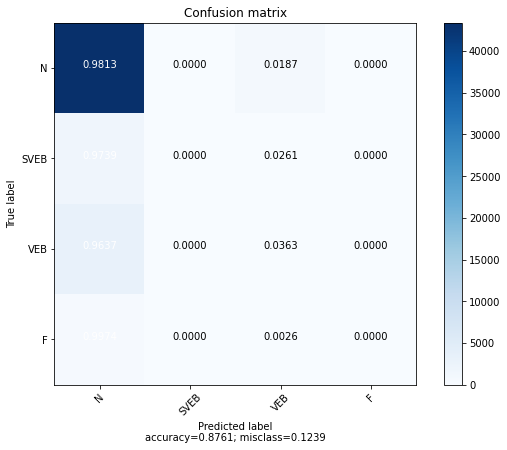

In [64]:
target_names = ["N","SVEB","VEB","F"]
plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True)

In [68]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     44218
           1       0.00      0.00      0.00      1836
           2       0.12      0.04      0.06      3219
           3       0.00      0.00      0.00       388

    accuracy                           0.88     49661
   macro avg       0.25      0.25      0.25     49661
weighted avg       0.80      0.88      0.84     49661



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
